# A multivariate regression problem

In [1]:
import pandas
import numpy as np
import sklearn.linear_model as lm
from sklearn.model_selection import KFold
from sklearn import preprocessing as pre
import random
import matplotlib.pyplot as plt

Load in the California housing dataset. Originally downloaded from https://github.com/ageron/handson-ml/tree/master/datasets/housing

In [2]:
housing = pandas.read_csv('./housing.csv')

In [3]:
display(housing)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


This dataset has some special features which need some attention:
1. The variable ocean_proximity is a categorical variable
2. There are some missing values in the total_bedrooms column
Let us consider how to deal with each of these.

First, deal with the categorical variable ocean_proximity. How many distinct values does this take?

In [4]:
print(set(housing.ocean_proximity.values))
print(len(set(housing.ocean_proximity.values)))

{'NEAR BAY', 'NEAR OCEAN', 'INLAND', 'ISLAND', '<1H OCEAN'}
5


There are five unique values and so we will replace this with a one-hot vector of length 5 where 10000 corresponds to <1H OCEAN, 01000 is ISLAND etc. This is a standard way to represent categorical factors. The key is that for any entry (row) only one element of this vector should be 1 - hence one-hot.

In [5]:
housing['1h_ocean'] = [1 if i=='<1H OCEAN' else 0 for i in housing.ocean_proximity.values]
housing['island'] = [1 if i=='ISLAND' else 0 for i in housing.ocean_proximity.values]
housing['inland'] = [1 if i=='INLAND' else 0 for i in housing.ocean_proximity.values]
housing['near_ocean'] = [1 if i=='NEAR OCEAN' else 0 for i in housing.ocean_proximity.values]
housing['near_bay'] = [1 if i=='NEAR BAY' else 0 for i in housing.ocean_proximity.values]
housing.drop(columns=['ocean_proximity'], inplace=True)
display(housing)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,island,inland,near_ocean,near_bay
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,0,1
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,0,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,0,1
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,0,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,0,1
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,0,0,0,0,1
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,0,0,0,0,1
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,0,0,0,0,1
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,0,0,0,0,1
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,0,0,0,0,1


Now we need to look at the missing values in total_bedrooms, of which there are:

In [6]:
sum(housing.total_bedrooms.isna())

207

How can we deal with this? It depends. There are several strategies one can use.

* Replace with the average of the column, but this loses information about correlation
* Replace with the values from the nearest neighbour, based on the values of the other variables.
* Use some prior knowledge.

We will use some prior knowledge that it is highly likely that the number of bedrooms is strongly correlated with the total number of rooms. We'll fit a linear model to predict the missing values.

In [7]:
# Get the non-Nan indices
notna = housing.total_bedrooms.notna()

In [8]:
model = lm.LinearRegression()
model.fit(housing.total_rooms.values[notna].reshape(-1,1), housing.total_bedrooms.values[notna].reshape(-1,1))
model.score(housing.total_rooms.values[notna].reshape(-1,1), housing.total_bedrooms.values[notna].reshape(-1,1))

0.8656060227407114

This is a strong prediction so our intuition is correct. Now we predict the missing values.

In [9]:
isna = housing.total_bedrooms.isna()
missing_bedrooms = model.predict(housing.total_rooms.values[isna].reshape(-1,1))

Insert the imputed values into the table.

In [10]:
# Can ignore subsequent warning
housing.total_bedrooms.loc[isna] = np.squeeze(missing_bedrooms)

C:\Users\Percival\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
display(housing)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,island,inland,near_ocean,near_bay
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,0,1
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,0,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,0,1
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,0,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,0,1
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,0,0,0,0,1
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,0,0,0,0,1
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,0,0,0,0,1
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,0,0,0,0,1
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,0,0,0,0,1


So we now have a complete dataset. Can we model it? An obvious thing to try first is a linear model, in which the house price is a weighted sum of the inputs; that is:
$$y = w_0 + w_1 x_1 + w_2 x_2 + w_M x_M$$
Let's assess this via cross-validation

In [12]:
# First, extract the data into arrays
y = housing.median_house_value.values.reshape(-1,1)
X = housing.drop(columns=['median_house_value'], inplace=False).values
print(X.shape)
print(y.shape)
# Pull out 1000 values into a holdout set
holdout = random.sample(range(0,10640),1000)
X_holdout = X[holdout]
y_holdout = y[holdout]
Xt = np.delete(X, holdout, 0)
yt = np.delete(y, holdout, 0)
print(Xt.shape)
print(yt.shape)

(20640, 13)
(20640, 1)
(19640, 13)
(19640, 1)


In [13]:
Model = lm.LinearRegression()
# Have to shuffle the data because it is grouped.
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(Xt):
    X_train, X_test = Xt[train_index], Xt[test_index]
    y_train, y_test = yt[train_index], yt[test_index]
    Model.fit(X_train, y_train)
    print('Training error: ' + str(Model.score(X_train, y_train)))
    print('Testing error: ' + str(Model.score(X_test, y_test)))

Training error: 0.6490620982582311
Testing error: 0.6443195732736859
Training error: 0.6517910525643784
Testing error: 0.631621934361466
Training error: 0.6460708146753187
Testing error: 0.6561294960962157
Training error: 0.6470284351024793
Testing error: 0.6527489327545286
Training error: 0.6476739221857637
Testing error: 0.6497055104703822


Scores quoted are $R^2$ (coefficient of determination) values which range from 0 to 1. These are OK but there is much room for improvement and we ought to be able to do much better than this. Options that we could try are:

* Normalising/rescaling the data so that all variables have similar values?
* Expanding the basis to include terms that are non-linear in the variables?
* Removing redundant variables from the data - are there any that are correlated with each other?
* Regularisation?

This will be the task of the group assignment.

## DATA EXPLORATION
the goal is to explore the data through visualizations and code to understand how each feature is related to the others. we will observe a statistical description of the dataset, consider the relevance of each features.

In [14]:
#Display a description of the dataset
# to understand on the count, mean, std, min, max and so on
display(housing.describe())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,island,inland,near_ocean,near_bay
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.737586,1425.476744,499.539680,3.870671,206855.816909,0.442636,0.000242,0.317393,0.128779,0.110950
std,2.003532,2.135952,12.585558,2181.615252,420.490677,1132.462122,382.329753,1.899822,115395.615874,0.496710,0.015563,0.465473,0.334963,0.314077
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## SCATTER PLOT
Scatter plots show how much one variable is affected by another.  The relationship between two variables is called their correlation.

C:\Users\Percival\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


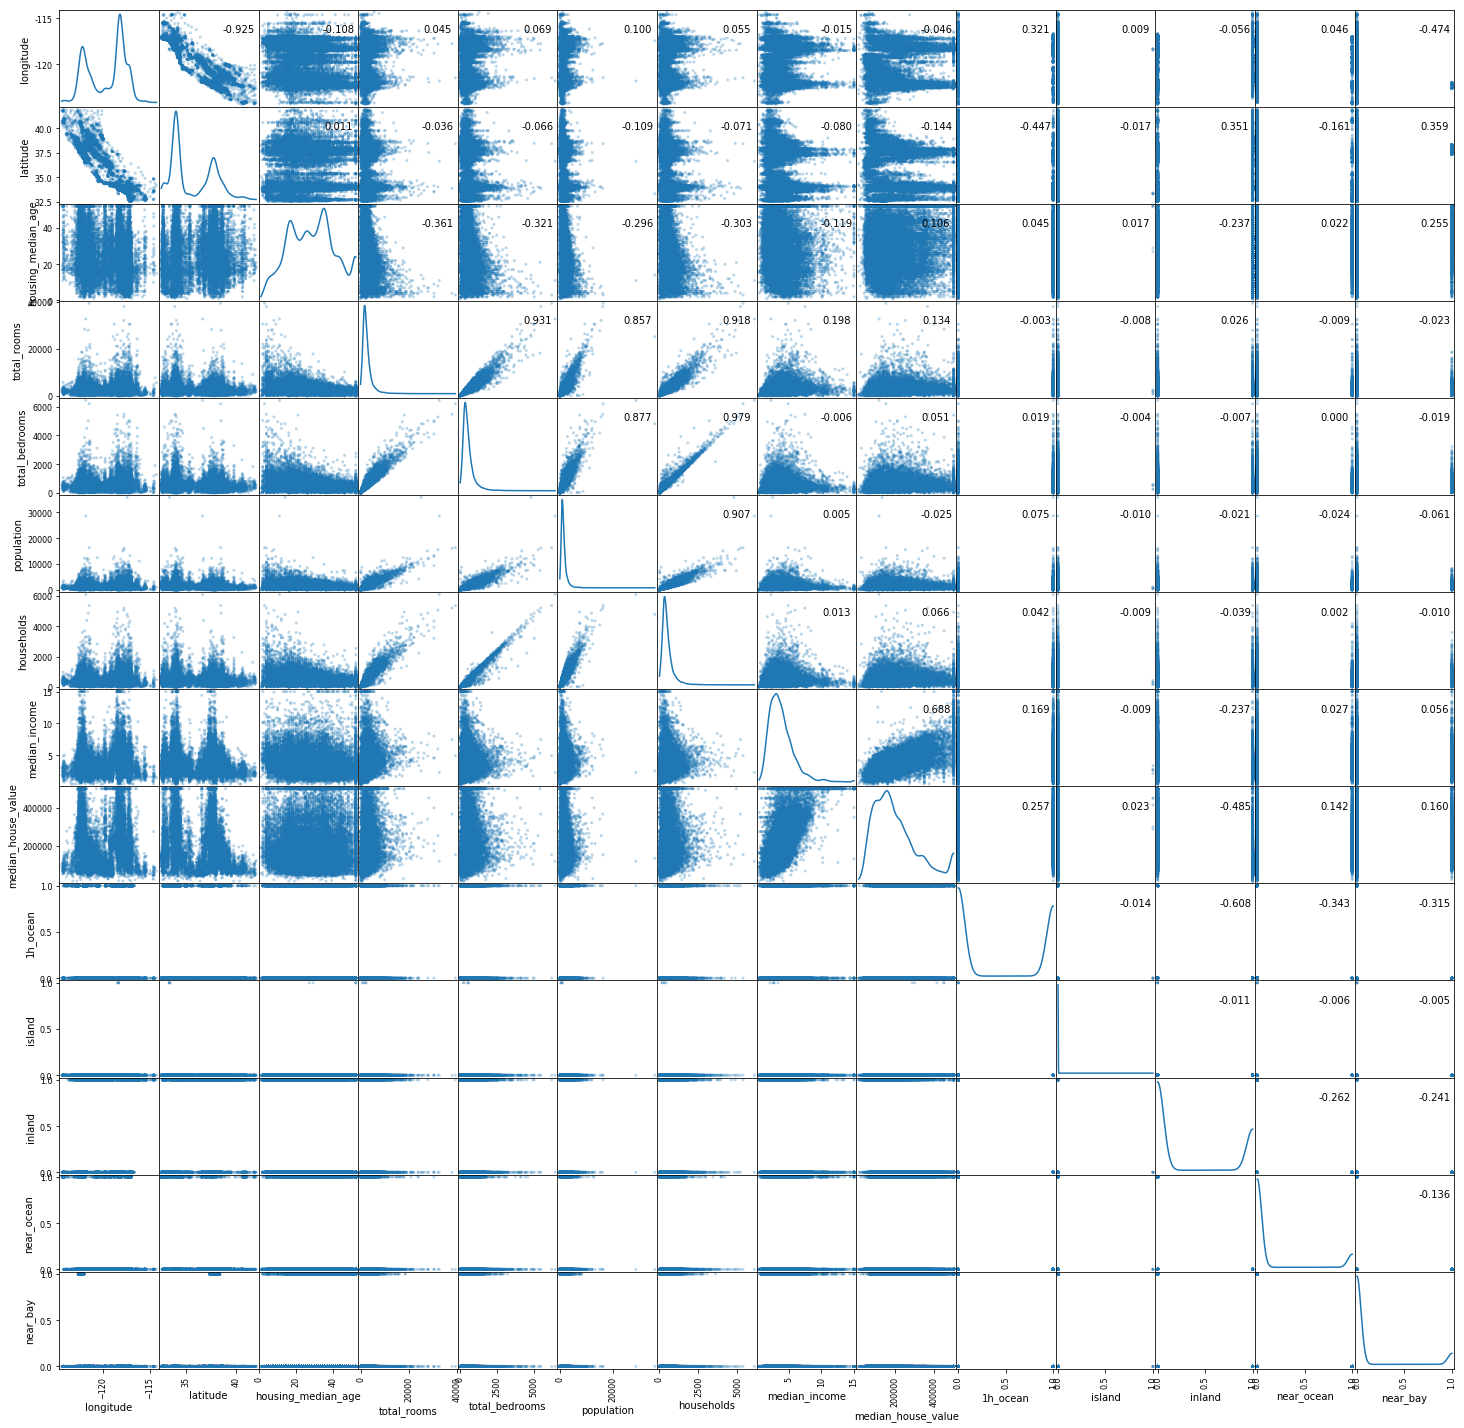

In [15]:
import pandas as pd
# Produce a scatter matrix for each pair of features in the data
axes = pd.scatter_matrix(housing, alpha = 0.3, figsize = (25,25), diagonal = 'kde')
corr = housing.corr().as_matrix()
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

## HEATMAP

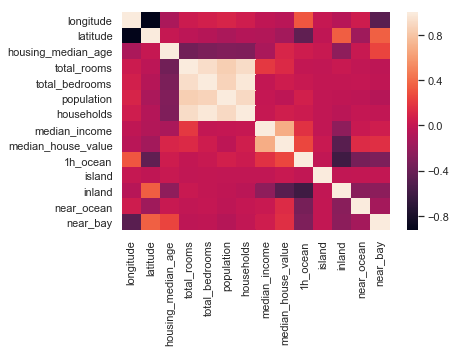

In [17]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(housing.corr())

## HISTOGRAM
histogram is a plot to show the underlying frequency distribution (shape) of a set of data.  This allows the inspection of the data for its underlying distribution (e.g. normal distribution), outliers, skewness, etc.

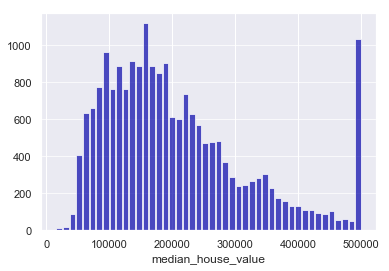

In [18]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.median_house_value.values.reshape(-1,1), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('median_house_value')
plt.grid(axis='y', alpha=0.75)

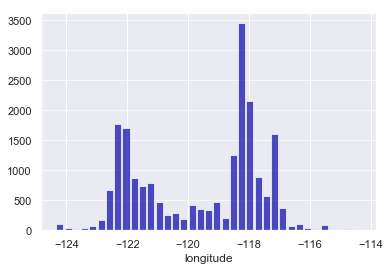

In [19]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.longitude, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('longitude')
plt.grid(axis='y', alpha=0.75)

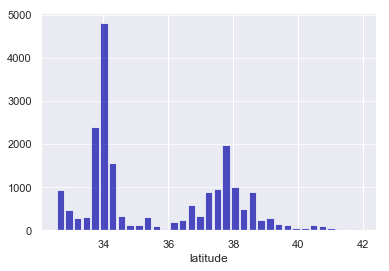

In [20]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.latitude, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('latitude')
plt.grid(axis='y', alpha=0.75)

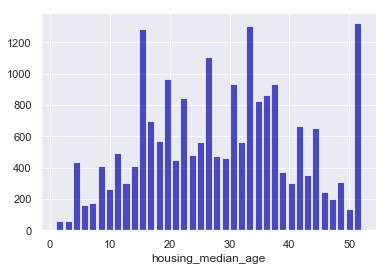

In [21]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.housing_median_age, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('housing_median_age')
plt.grid(axis='y', alpha=0.75)

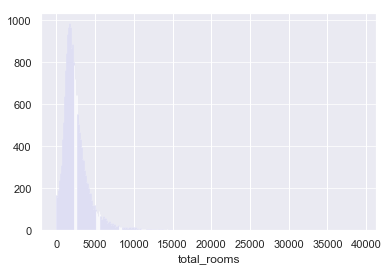

In [22]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.total_rooms, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('total_rooms')
plt.grid(axis='y', alpha=0.75)

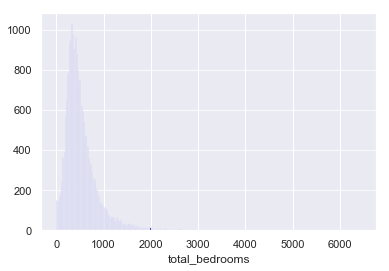

In [23]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.total_bedrooms, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('total_bedrooms')
plt.grid(axis='y', alpha=0.75)

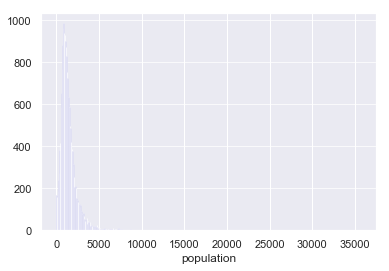

In [24]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.population, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('population')
plt.grid(axis='y', alpha=0.75)

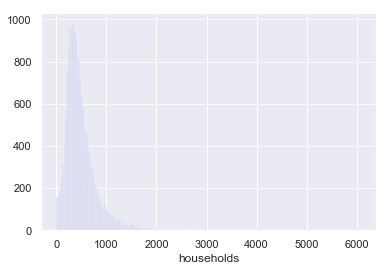

In [25]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.households, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('households')
plt.grid(axis='y', alpha=0.75)

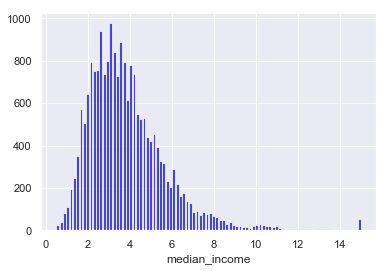

In [26]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.median_income, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('median_income')
plt.grid(axis='y', alpha=0.75)

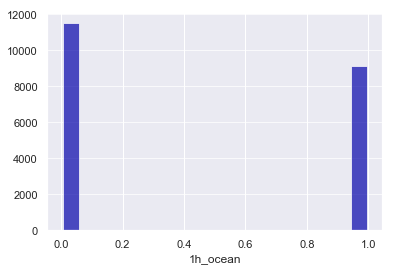

In [27]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing['1h_ocean'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('1h_ocean')
plt.grid(axis='y', alpha=0.75)

## Peason's Correlation
The Pearson product-moment correlation coefficient is a measure of the strength of the linear relationship between two variables. It is referred to as Pearson's correlation or simply as the correlation coefficient. If the relationship between the variables is not linear, then the correlation coefficient does not adequately represent the strength of the relationship between the variables.

The symbol for Pearson's correlation is "ρ" when it is measured in the population and "r" when it is measured in a sample. Because we will be dealing almost exclusively with samples, we will use r to represent Pearson's correlation unless otherwise noted.

Pearson's r can range from -1 to 1. An r of -1 indicates a perfect negative linear relationship between variables, an r of 0 indicates no linear relationship between variables, and an r of 1 indicates a perfect positive linear relationship between variables. Figure 1 shows a scatter plot for which r = 1.

(ref: http://onlinestatbook.com/2/describing_bivariate_data/pearson.html)

## Spearman’s Correlation
Two variables may be related by a nonlinear relationship, such that the relationship is stronger or weaker across the distribution of the variables.

Further, the two variables being considered may have a non-Gaussian distribution.

In this case, the Spearman’s correlation coefficient (named for Charles Spearman) can be used to summarize the strength between the two data samples. This test of relationship can also be used if there is a linear relationship between the variables, but will have slightly less power (e.g. may result in lower coefficient scores).

As with the Pearson correlation coefficient, the scores are between -1 and 1 for perfectly negatively correlated variables and perfectly positively correlated respectively.

Instead of calculating the coefficient using covariance and standard deviations on the samples themselves, these statistics are calculated from the relative rank of values on each sample. This is a common approach used in non-parametric statistics, e.g. statistical methods where we do not assume a distribution of the data such as Gaussian.


Spearman's correlation coefficient = covariance(rank(X), rank(Y)) / (stdv(rank(X)) * stdv(rank(Y)))
1
Spearman's correlation coefficient = covariance(rank(X), rank(Y)) / (stdv(rank(X)) * stdv(rank(Y)))
A linear relationship between the variables is not assumed, although a monotonic relationship is assumed. This is a mathematical name for an increasing or decreasing relationship between the two variables.

If you are unsure of the distribution and possible relationships between two variables, Spearman correlation coefficient is a good tool to use.

Ref: https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/

In [28]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing.longitude
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("longitude v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

longitude v median_house_value
Pearsons correlation: -0.046
Spearmans correlation: -0.070


In [29]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing.latitude
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("latitude v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

latitude v median_house_value
Pearsons correlation: -0.144
Spearmans correlation: -0.166


In [30]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing.housing_median_age
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("housing_median_age v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

housing_median_age v median_house_value
Pearsons correlation: 0.106
Spearmans correlation: 0.075


In [31]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing.total_rooms
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("total_rooms v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

total_rooms v median_house_value
Pearsons correlation: 0.134
Spearmans correlation: 0.206


In [32]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing.total_bedrooms
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("total_bedrooms v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

total_bedrooms v median_house_value
Pearsons correlation: 0.051
Spearmans correlation: 0.088


In [33]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing.population
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("population v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

population v median_house_value
Pearsons correlation: -0.025
Spearmans correlation: 0.004


In [34]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing.households
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("households v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

households v median_house_value
Pearsons correlation: 0.066
Spearmans correlation: 0.113


In [35]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing.median_income
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("median_income v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

median_income v median_house_value
Pearsons correlation: 0.688
Spearmans correlation: 0.677


In [36]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing['island']
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("['island'] v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

['island'] v median_house_value
Pearsons correlation: 0.023
Spearmans correlation: 0.021


In [37]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing['inland']
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("['inland'] v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

['inland'] v median_house_value
Pearsons correlation: -0.485
Spearmans correlation: -0.566


In [38]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing['near_ocean']
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("['near_ocean'] v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

['near_ocean'] v median_house_value
Pearsons correlation: 0.142
Spearmans correlation: 0.143


In [39]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# prepare data
y = housing.median_house_value
x = housing['near_bay']
# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print("['near_bay'] v median_house_value")
print('Pearsons correlation: %.3f' % corr)
# calculate the spearmans's correlation between two variables
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

['near_bay'] v median_house_value
Pearsons correlation: 0.160
Spearmans correlation: 0.160
